<h1>Практическая работа: "Знакомство с алгоритма k-ближайших соседей (kNN)"</h1>

__K-ближайший сосед с использованием scikit-learn__

__Задача обучения__  
Набор данных "Ирисы Фишера". Нужно определить к какому классу принадлежит неопознанное растение ириса,
Классификация осуществляется на основе размеров чашелистиков и лепестков.

In [562]:
#Импорт необходимых библиотек
import warnings

warnings.filterwarnings('ignore')

In [563]:
#!pip install mlxtend

In [564]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from mlxtend.plotting import plot_decision_regions

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)

__Изучение набора данных__  
Набор данных "Ирисы Фишера" — это популярный многомерный набор данных, часто используемый в машинном обучении. 
Набор данных состоит из 150 образцов, равномерно распределенных по трем видам ирисов: 
ирис сетозный, ирис виргинский, ирис разноцветный. 
Каждый образец состоит из четырех атрибутов: длины и ширины чашелистиков и лепестков в сантиметрах.
Задача состоит в том, чтобы предсказать, к какому классу принадлежит неопознанное растение ириса,
основываясь на размерах чашелистиков и лепестков.

In [565]:
dataset = datasets.load_iris()
df = pd.DataFrame(data=np.c_[dataset['data'], dataset['target']],
                    columns=dataset['feature_names'] + ['target'])

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


__Описания наборов данных__

In [566]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


In [567]:
dict(zip( dataset.target_names, df['target'].unique()))

{np.str_('setosa'): np.float64(0.0),
 np.str_('versicolor'): np.float64(1.0),
 np.str_('virginica'): np.float64(2.0)}

In [568]:
temp_df = df.copy()

temp_df['target'] = temp_df['target'].map(dict(zip( temp_df['target'].unique(), dataset.target_names)))

<Axes: xlabel='target', ylabel='count'>

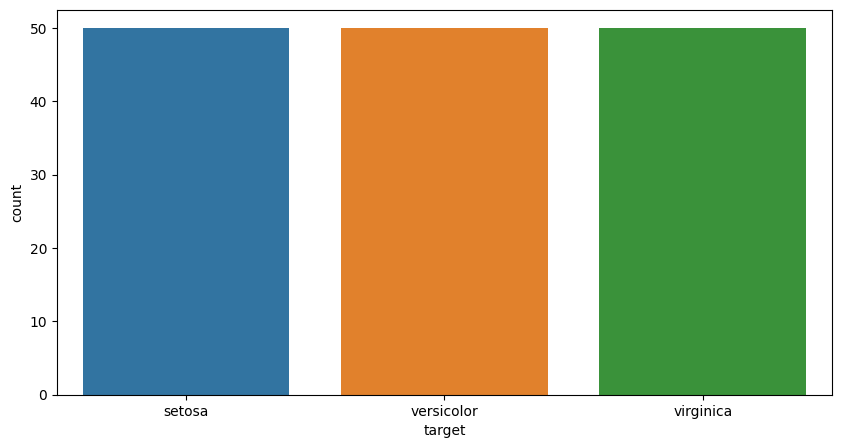

In [569]:
sns.countplot(x='target', hue='target', data=temp_df)

Из графика выше мы видим, что наши данные идеально сбалансированы.

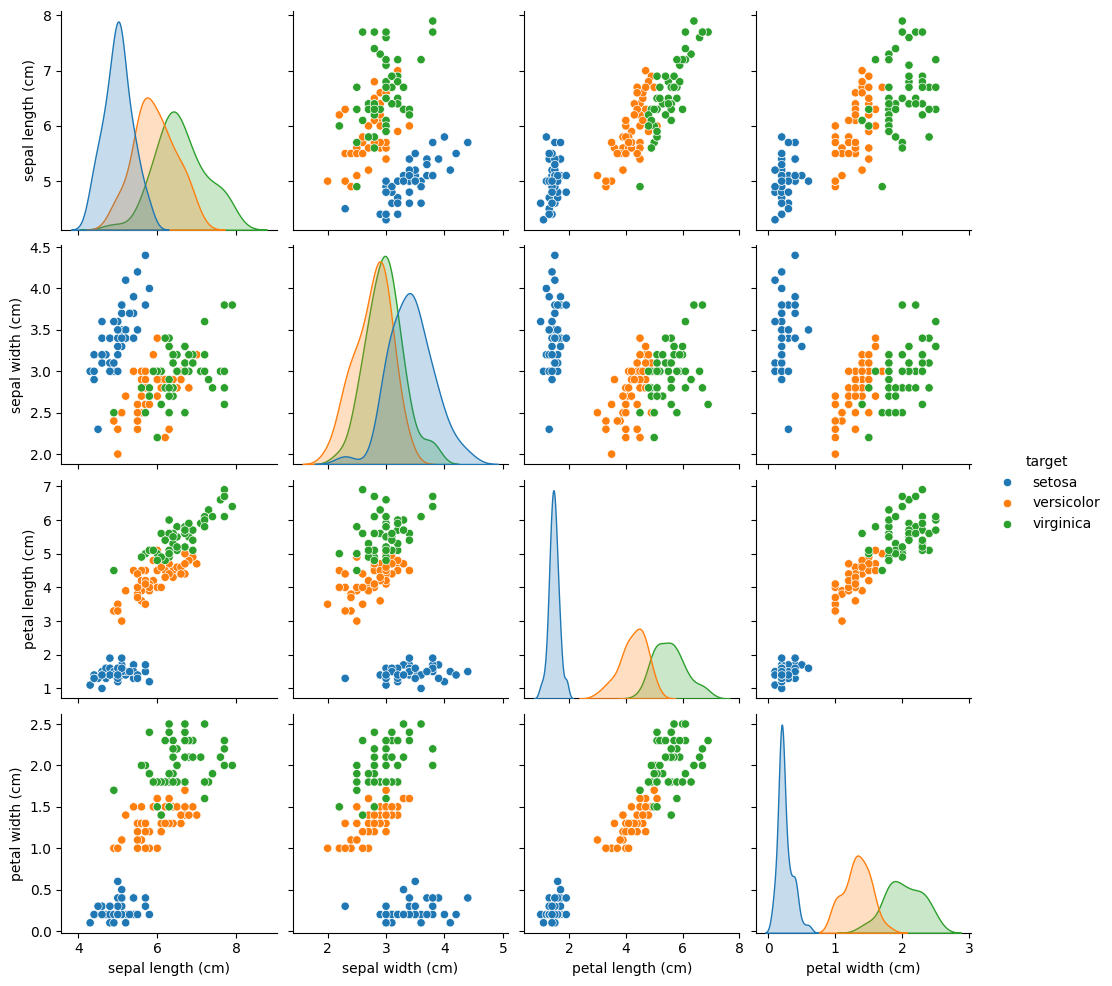

In [570]:
sns.pairplot(temp_df, hue='target')

На графике выше мы можем видеть взаимосвязь между каждой функцией. Мы можем увидеть, являются ли признаки разделимыми или нет.

<h2>Синтетический набор данных KNN</h2>

In [571]:
from IPython.display import display, Javascript, HTML
from IPython.display import IFrame
display(HTML('build.html'))

<h2>Модели КNN</h2>

Теперь мы построим разные модели для разных пар признаков, чтобы увидеть, насколько полезны признаки для определения их вида.

In [572]:
# Helper functions

def display_confusion_matrix(
    matrix, labels=None,
    title="Confusion Matrix",
    xlabel="Predicted",
    ylabel="Actual",
    figsize=None,
    cmap="Blues",
    vmin=None,
    vmax=None,
):
    """Display a confusion matrix.

    Display the confusion matrix found in matrix using matplotlib.

    Parameters
    ----------
    matrix : array-like
        Confusion matrix to display, shape [n_classes, n_classes].

    labels : array-like, default=None
        Class labels for the confusion matrix, shape [n_classes].

    title : str, default='Confusion Matrix'
        Title displayed on the confusion matrix.

    xlabel : str, default='Predicted'
        x-label displayed on the confusion matrix.

    ylabel : str, default='Actual'
        y-label displayed on the confusion matrix.

    figsize : array-like
        Array-like, length two, specifying the figsize of the plot.

    cmap : matplotib.colors.Colormap or str, default='Blues'
        Colormap used when displaying the entries of the confusion matrix.

    vmin,vmax : int or float
        *vmin* and *vmax* define the data range that the colormap covers.
    """

    if labels is None:
        labels = [""]*len(matrix)
    if vmin is None:
        vmin = 0.
    if vmax is None:
        vmax = np.sum(matrix[0])
    t_hold = (vmax-vmin) / 2.
    fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(matrix, cmap=cmap)
    for row,col in itertools.product(range(len(labels)), range(len(labels))):
        color = "white" if matrix[row,col] > t_hold else "black"
        ax.text(col, row, matrix[row, col], horizontalalignment="center", color=color)
    tick_marks = np.arange(len(labels))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=40, ha="right")
    ax.set_ylabel(ylabel)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    plt.show()

<h2>Модель 1 (длина чашелистика и ширина чашелистика)</h2>  
Для начала мы собираемся построить модель KNN с длиной и шириной чашелистика. Мы обучим модель этим двум функциям и оценим ее эффективность с помощью карты классификации и матрицы путаницы.

In [573]:
X = df[['sepal length (cm)', 'sepal width (cm)']]
y_true = df['target']
model_1 = KNeighborsClassifier()
model_1.fit(X, y_true)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


<h3>Оценка модели 1</h3>

<Axes: >

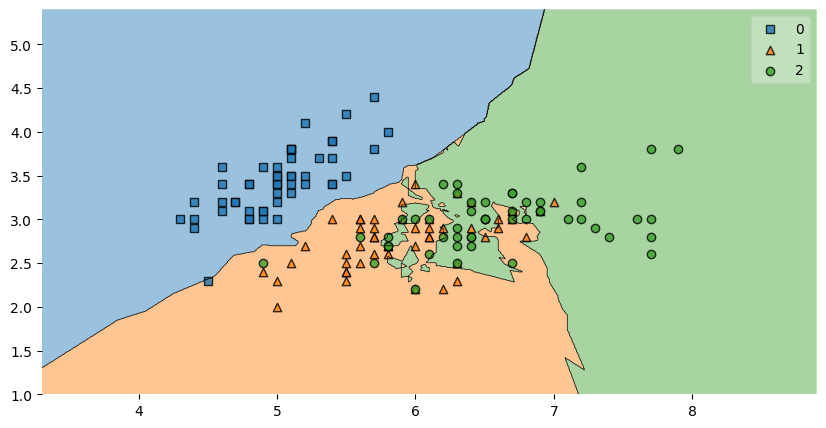

In [574]:
plot_decision_regions(X.values, y_true.values.astype(int), model_1)

[[49  1  0]
 [ 0 37 13]
 [ 0 10 40]]


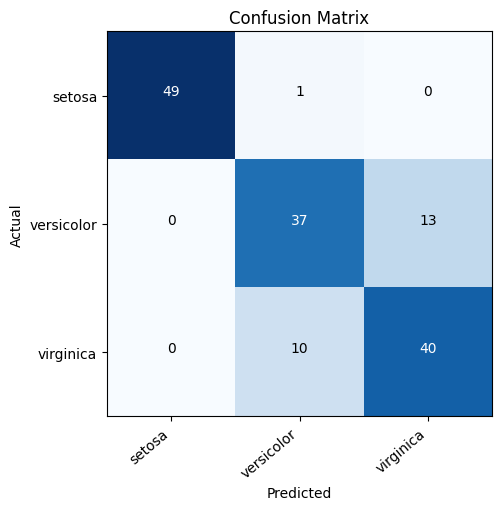

In [575]:
y_hat = model_1.predict(X)
labels = df["target"].unique()

matrix = confusion_matrix(y_true, y_hat, labels=labels, normalize=None)
print(matrix)

display_confusion_matrix(matrix, dataset.target_names)

<h1>Модель 2 (длина и ширина лепестка)</h1>  
Теперь для нашей второй модели мы собираемся использовать функции длины и ширины лепестка в качестве входных данных.

In [576]:
X = df[['petal length (cm)', 'petal width (cm)']]

model_2 = KNeighborsClassifier()
model_2.fit(X, y_true)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


__Model 2 Evaluation__

<Axes: >

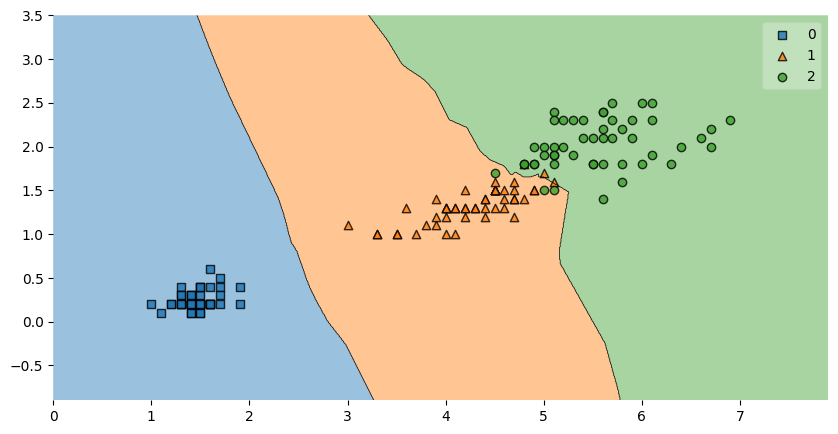

In [577]:
plot_decision_regions(X.values, y_true.values.astype(int), model_2)

[[50  0  0]
 [ 0 47  3]
 [ 0  3 47]]


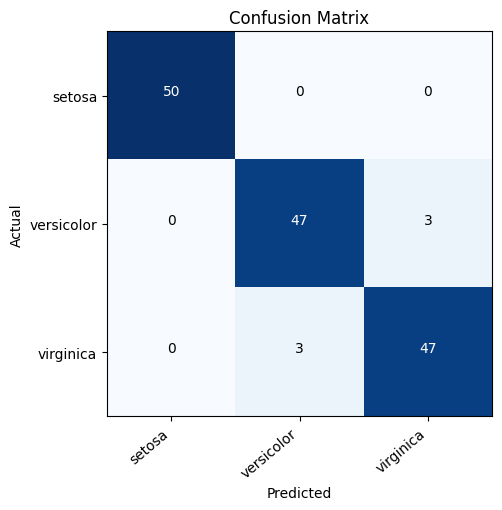

In [578]:
y_hat = model_2.predict(X)

matrix = confusion_matrix(y_true, y_hat, labels=labels, normalize=None)
print(matrix)

display_confusion_matrix(matrix, dataset.target_names)

<h1>Модель 3 (все функции)</h1>  
Теперь что касается нашей окончательной модели, мы собираемся использовать все доступные функции и обучить нашу модель KNN.

In [579]:
X = df.drop(['target'], axis=1)

In [580]:
model_3 = KNeighborsClassifier()
model_3.fit(X, y_true)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


__Модель 3 Оценка__

[[50  0  0]
 [ 0 47  3]
 [ 0  2 48]]


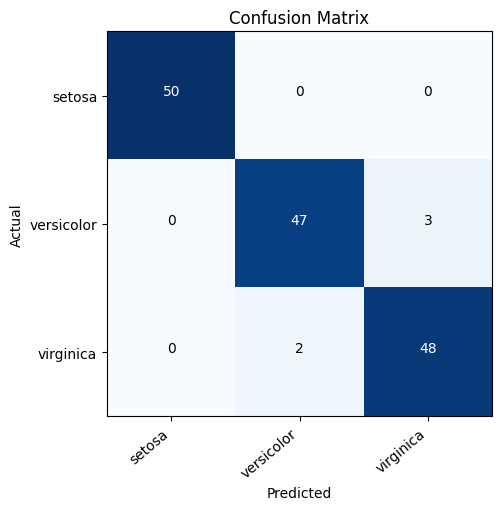

In [581]:
y_hat = model_3.predict(X)

matrix = confusion_matrix(y_true, y_hat, labels=labels, normalize=None)
print(matrix)

display_confusion_matrix(matrix, dataset.target_names)

Вы можете видеть, что окончательная модель со всеми функциями работает лучше, чем все другие модели. Меньше ошибочной классификации.

Однако до сих пор мы обучали и оценивали наши модели в одном и том же наборе данных. Использование одних и тех же данных для обучения и оценки не рекомендуется.

__Модель на разделенном наборе данных__

Здесь мы разделим наш набор данных на обучающий и тестовый набор и обучим нашу модель в обучающем наборе. Позже во время оценки мы собираемся использовать наш изолированный набор тестов.

In [582]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [583]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [584]:
preds = knn.predict(X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       0.87      1.00      0.93        13
         2.0       1.00      0.88      0.94        17

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



[[15  0  0]
 [ 0 13  2]
 [ 0  0 15]]


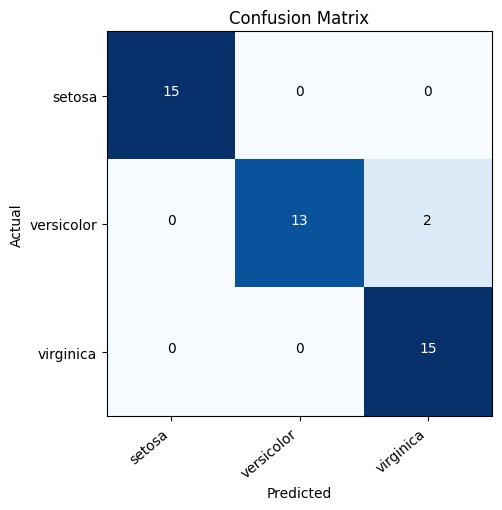

In [585]:
matrix = confusion_matrix(y_test, preds, labels=y.unique(), normalize=None)
print(matrix)

display_confusion_matrix(matrix, dataset.target_names)

Выше вы можете видеть, что точность нашего набора тестовых данных составляет 98%.

Из матрицы путаницы мы также видим, что у нас очень низкий уровень ошибок классификации.

Для наших вышеупомянутых моделей мы также можем использовать данные обучения и тестирования отдельно, оценивать эти модели, а затем выбирать лучшую модель.

<h1>Задание</h1>  
С помощью метода kNN определить качество красного вина. Использовать датасет winequality-red.csv, который находится в папке data.
Для этого разделить набор данных на обучающий и тестовый набор и обучим нашу модель в обучающем наборе. 
Построить матрицу путаници. Сделать выводы по полученным результатам. 

Матрица путанницы:
[[264   9]
 [ 37  10]]


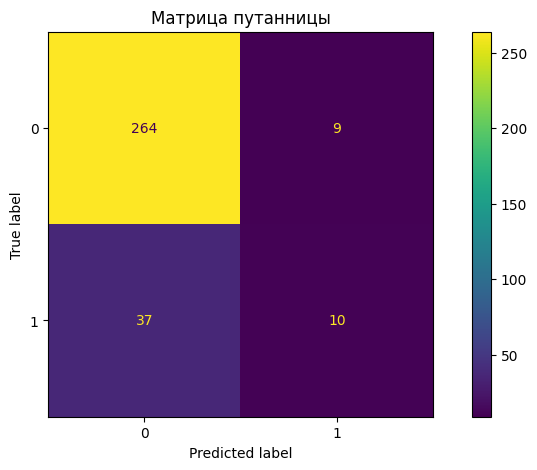

Accuracy: 0.8562
Precision: 0.5263
Recall: 0.2128
F1: 0.3030


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Подготовка данных
df = pd.read_csv('winequality-red.csv', sep=',')

df['quality'] = (df['quality'] >= 7).astype(int)

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели kNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Построение матрицы путанницы
cm = confusion_matrix(y_test, y_pred)
print("Матрица путанницы:")
print(cm)

# Визуализация матрицы путанницы
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Матрица путанницы")
plt.show()

# Расчёт метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

Распределение классов после балансировки в train:
quality
0    1109
1    1109
Name: count, dtype: int64

Матрица путаницы после балансировки:
[[213  60]
 [  7  40]]


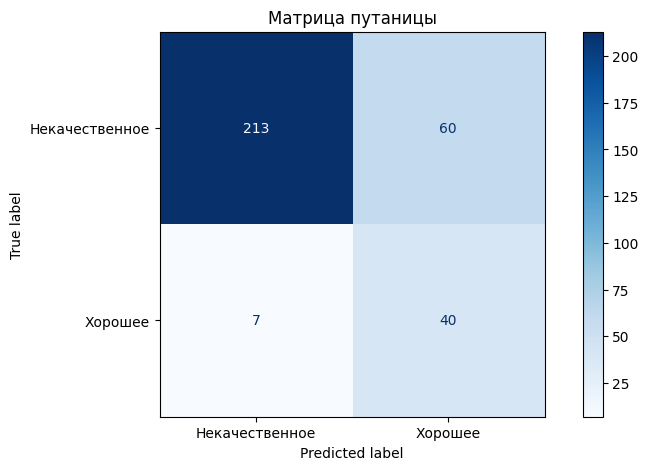


Метрики после балансировки:
Accuracy: 0.7906
Precision: 0.4000
Recall: 0.8511
F1: 0.5442


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Подготовка данных
df = pd.read_csv('winequality-red.csv', sep=',')

df['quality'] = (df['quality'] >= 7).astype(int)

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Балансировка с SMOTE на нормализованных данных
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# Проверка распределения после балансировки
print("Распределение классов после балансировки в train:")
print(pd.Series(y_train_bal).value_counts())

# Обучение kNN
knn_bal = KNeighborsClassifier(n_neighbors=7)
knn_bal.fit(X_train_bal, y_train_bal)

y_pred_bal = knn_bal.predict(X_test_scaled)

# Матрица путанницы
cm_bal = confusion_matrix(y_test, y_pred_bal)
print("\nМатрица путаницы после балансировки:")
print(cm_bal)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_bal, display_labels=['Некачественное', 'Хорошее'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Матрица путаницы")
plt.show()

# Метрики
accuracy_bal = accuracy_score(y_test, y_pred_bal)
precision_bal = precision_score(y_test, y_pred_bal)
recall_bal = recall_score(y_test, y_pred_bal)
f1_bal = f1_score(y_test, y_pred_bal)

print("\nМетрики после балансировки:")
print(f"Accuracy: {accuracy_bal:.4f}")
print(f"Precision: {precision_bal:.4f}")
print(f"Recall: {recall_bal:.4f}")
print(f"F1: {f1_bal:.4f}")